# Lab6: Wordnet (słowosieć)

In [1]:
import json
import math
import nltk
from nltk.corpus import wordnet as wn
import queue
import requests

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
BASE_URL = 'http://api.slowosiec.clarin-pl.eu/plwordnet-api/'

## Read the [Wordnet API](http://api.slowosiec.clarin-pl.eu/docs/index.html)
## Get acquainted with semantic relations in WordNet.
## Find all meanings of the _szkoda_ noun and display all their synonyms.

Odnalezione zostały dwa znaczenia słowa _szkoda_.

In [3]:
def send_request(operation=''):
    url = f'{BASE_URL}{operation}'
    return json.loads(requests.get(url).content.decode('utf-8'))

In [12]:
response = send_request('senses/search?lemma=szkoda&partOfSpeech=noun')
response

{'content': [{'id': 8769,
   'domain': {'id': 12,
    'name': 'plWN_msc',
    'description': 'plWN miejsca i umiejscowienie',
    'lexicon': {'id': 1,
     'name': 'Słowosieć 2.2',
     'lexiconIdentifier': 'P 2.2',
     'language': 'pl'}},
   'lemma': {'id': 249489, 'word': 'szkoda'},
   'partOfSpeech': {'id': 2,
    'name': 'plWN rzeczownik',
    'lexicon': {'id': 1,
     'name': 'Słowosieć 2.2',
     'lexiconIdentifier': 'P 2.2',
     'language': 'pl'},
    'lmfType': 'noun'},
   'senseNumber': 1,
   'lexicon': {'id': 1,
    'name': 'Słowosieć 2.2',
    'lexiconIdentifier': 'P 2.2',
    'language': 'pl'}},
  {'id': 8771,
   'domain': {'id': 18,
    'name': 'plWN_pos',
    'description': 'plWN posiadanie i jego zmiana',
    'lexicon': {'id': 1,
     'name': 'Słowosieć 2.2',
     'lexiconIdentifier': 'P 2.2',
     'language': 'pl'}},
   'lemma': {'id': 249489, 'word': 'szkoda'},
   'partOfSpeech': {'id': 2,
    'name': 'plWN rzeczownik',
    'lexicon': {'id': 1,
     'name': 'Słowosie

In [307]:
meanings = {param['id']: param['domain']['description'] for param in response['content']}
meanings

{8769: 'plWN miejsca i umiejscowienie', 8771: 'plWN posiadanie i jego zmiana'}

In [308]:
for meaning_id, description in meanings.items():
    synset_id = send_request(f'senses/{meaning_id}/synset')['id']
    result = send_request(f'synsets/{synset_id}/senses')
    synonyms = [param['lemma']['word'] for param in result]
    print(f'{meaning_id}\t{description}\t{", ".join(synonyms)}')

8769	plWN miejsca i umiejscowienie	szkoda
8771	plWN posiadanie i jego zmiana	strata, utrata, szkoda, uszczerbek


## Find closure of hypernymy relation for the first meaning of the _wypadek drogowy_ expression. Create diagram of the relations as a directed graph.

Przygotowane zostały metody pomocnicze do rysowania grafów oraz oraz podstawowych zapytań do WordNetu.

In [4]:
def show_graph(edges, labels=None):
    G = nx.DiGraph()
    G.add_edges_from(edges)

    pos = nx.spring_layout(G)

    plt.figure(figsize=(16, 8))

    nx.draw(G, pos, with_labels=True)

    if labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    plt.show()

In [5]:
def get_synset_id(expression, part_of_speech=None, meaning_no=1):
    try:
        path = f'senses/search?lemma={expression}' + (f'&partOfSpeech={part_of_speech}' if part_of_speech else '')
        response = send_request(path)
        meaning_id = response['content'][meaning_no - 1]['id']
        return send_request(f'senses/{meaning_id}/synset')['id']
    except IndexError:
        print(f'{expression} {meaning_no} not found')

In [6]:
def get_expressions_from_synset_id(synset_id):
    try:
        response = send_request(f'synsets/{synset_id}/senses')
        return [sense['lemma']['word'] for sense in response]
    except TypeError:
        return get_expressions_from_synset_id(synset_id)

In [7]:
def find_relations(synset_id, relation_name, distance=0, limit=5):
    edges = []
    if distance == limit:
        return edges

    response = send_request(f'synsets/{synset_id}/relations/to')
    results = [
        (param['synsetFrom']['id'], param['synsetTo']['id']) 
        for param
        in response if param['relation']['name'] == relation_name
    ]

    for src_synset_id, dest_synset_id in results:
        try:
            src_synset = get_expressions_from_synset_id(src_synset_id)
            dest_synset =  get_expressions_from_synset_id(dest_synset_id)
            src_synset = ', '.join(src_synset)
            dest_synset = ', '.join(dest_synset)
            print(f'{src_synset} ({src_synset_id}) -> {dest_synset} ({dest_synset_id})')
            edges.append((src_synset, dest_synset))
            edges += find_relations(src_synset_id, relation_name, distance + 1, limit)
        except TypeError:
            print(f'Skipping {src_synset_id} -> {dest_synset_id}')

    return edges

Poniżej przedstawiony jest graf relacji dla hiperonimów wyrażenia _wypadek drogowy_.

wypadek komunikacyjny (410901) -> wypadek drogowy (410902)
wypadek (3982) -> wypadek komunikacyjny (410901)
zdarzenie oceniane negatywnie (27419) -> wypadek (3982)
wydarzenie, historia, wypadek, zdarzenie (6526) -> zdarzenie oceniane negatywnie (27419)


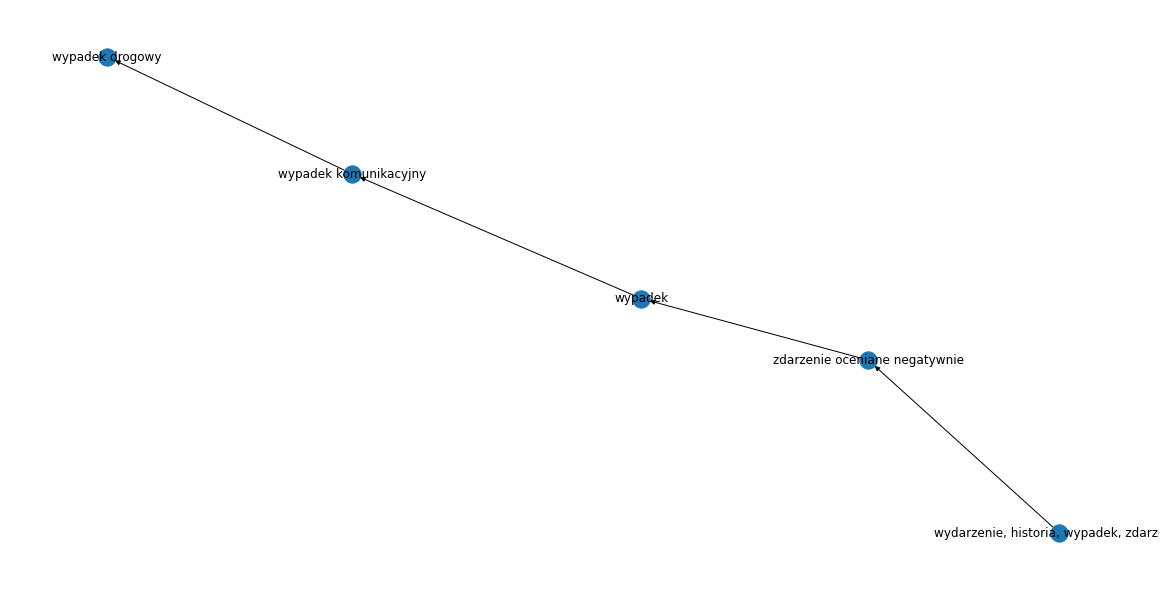

In [313]:
synset_id = get_synset_id('wypadek drogowy')
edges = find_relations(synset_id, 'hiperonimia')
show_graph(edges)

## Find direct hyponyms of _wypadek$_{1}$_ noun.

Poniżej przedstawiony jest graf relacji dla hiponimów wyrażenia _wypadek_.

zawał (34688) -> wypadek (3982)
tąpnięcie (34689) -> wypadek (3982)
katastrofa (258635) -> wypadek (3982)
wykolejenie (258639) -> wypadek (3982)
zakrztuszenie, zachłyśnięcie (389170) -> wypadek (3982)
wypadek komunikacyjny (410901) -> wypadek (3982)
katastrofa budowlana (411618) -> wypadek (3982)


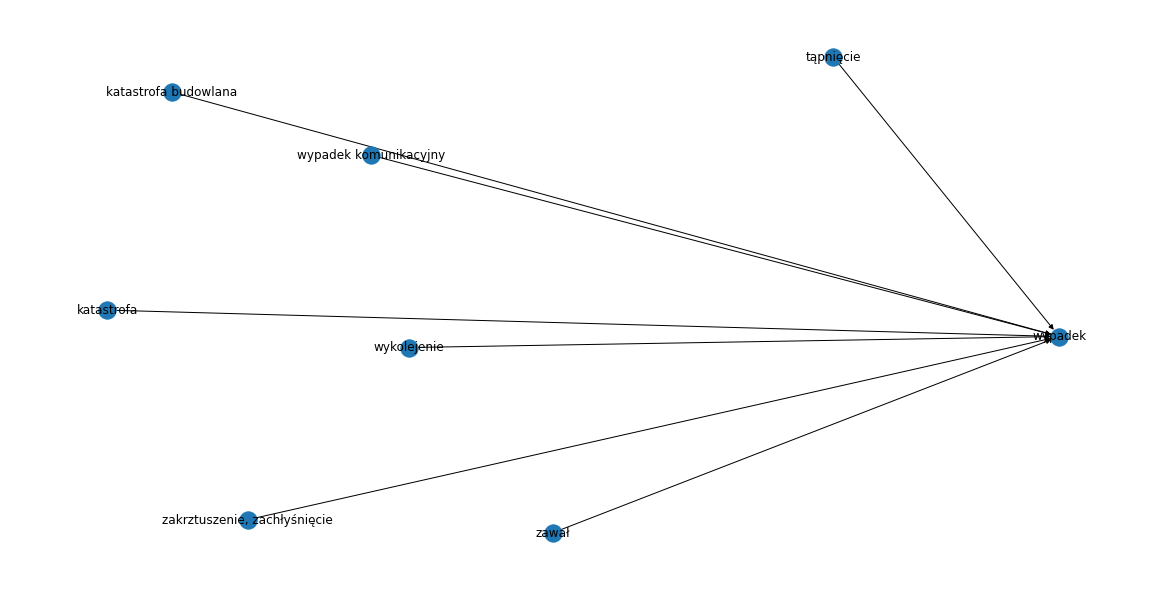

In [314]:
synset_id = get_synset_id('wypadek', 'noun')
edges = find_relations(synset_id, 'hiponimia', limit=1)
show_graph(edges)

## Find second-order hyponyms of the same noun.

Poniżej przedstawiony jest graf relacji dla hiponimów drugiego stopnia wyrażenia _wypadek_.

zawał (34688) -> wypadek (3982)
obwał (37295) -> zawał (34688)
tąpnięcie (34689) -> wypadek (3982)
katastrofa (258635) -> wypadek (3982)
wykolejenie (258639) -> wypadek (3982)
zakrztuszenie, zachłyśnięcie (389170) -> wypadek (3982)
wypadek komunikacyjny (410901) -> wypadek (3982)
wypadek drogowy (410902) -> wypadek komunikacyjny (410901)
katastrofa budowlana (411618) -> wypadek (3982)


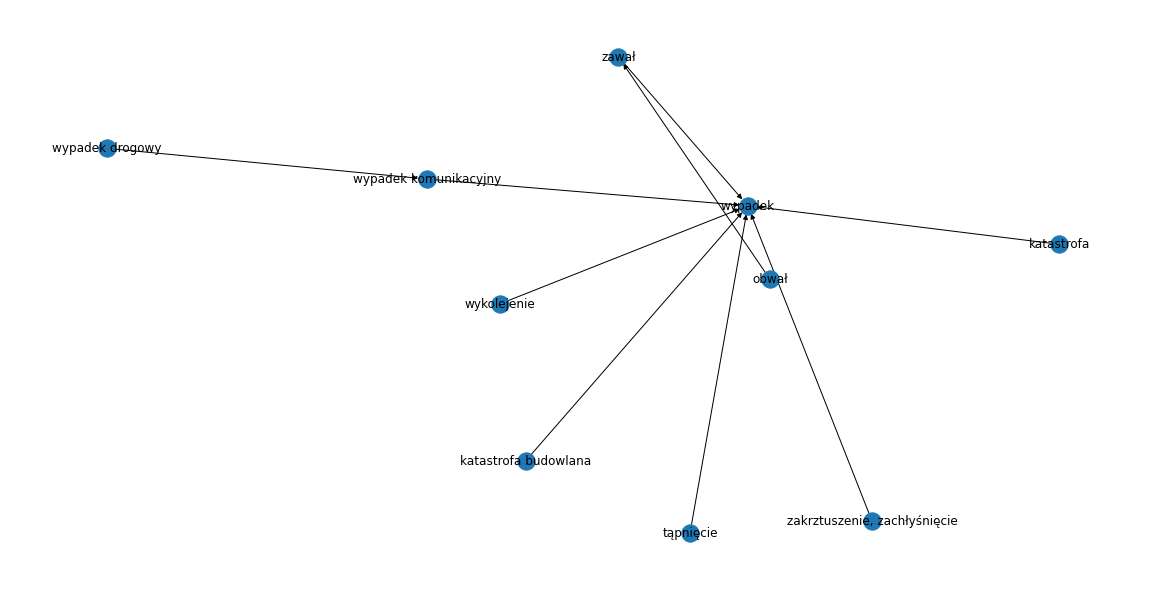

In [316]:
synset_id = get_synset_id('wypadek', 'noun')
edges = find_relations(synset_id, 'hiponimia', limit=2)
show_graph(edges)

## Display as a directed graph (with labels for the edges) semantic relations between the following groups of lexemes:

Przygotowana została metoda pomocnicza.

In [317]:
def find_relations(synset_ids):
    edges = []
    edge_labels = {}
    
    for synset_id in synset_ids:
        for relation in send_request(f'synsets/{synset_id}/relations/to'):

            if not 'synsetFrom' in relation or not 'synsetTo' in relation:
                print(f'Skipping {relation}')
                continue

            src_synset_id, dest_synset_id = relation['synsetFrom']['id'], relation['synsetTo']['id']
            relation_name = relation['relation']['name']
            
            if src_synset_id not in synset_ids or dest_synset_id not in synset_ids:
                continue
                                
            src_synset = get_expressions_from_synset_id(src_synset_id)
            src_synset = ', '.join(src_synset)

            dest_synset = get_expressions_from_synset_id(dest_synset_id)
            dest_synset = ', '.join(dest_synset)
            
            print(f'{src_synset} - {relation_name} -> {dest_synset}')
            
            edge = (src_synset, dest_synset)
            if edge not in edges and (edge[1], edge[0]) not in edges:
                edges += [edge]
                edge_labels[edge] = relation_name

    return edges, edge_labels

### szkoda$_{2}$, strata$_{1}$, uszczerbek$_{1}$, szkoda majątkowa$_{1}$, uszczerbek na zdrowiu$_{1}$, krzywda$_{1}$, niesprawiedliwość$_{1}$, nieszczęście$_{2}$.


Poniżej widoczny jest graf relacji dla zadanej grupy wyrażeń. Nie odnaleziono frazy _szkoda majątkowa$_{1}$_.

In [324]:
synset_ids = [
    get_synset_id('szkoda', meaning_no=2),
    get_synset_id('strata', meaning_no=1),
    get_synset_id('uszczerbek', meaning_no=1),
    get_synset_id('szkoda majątkowa', meaning_no=1),
    get_synset_id('uszczerbek na zdrowiu', meaning_no=1),
    get_synset_id('krzywda', meaning_no=1),
    get_synset_id('niesprawiedliwość', meaning_no=1),
    get_synset_id('nieszczęście', meaning_no=2),
]

szkoda majątkowa 1 not found


krzywda, niesprawiedliwość - hiponimia -> strata, utrata, szkoda, uszczerbek
uszczerbek na zdrowiu - hiponimia -> strata, utrata, szkoda, uszczerbek
krzywda, niesprawiedliwość - hiponimia -> strata, utrata, szkoda, uszczerbek
uszczerbek na zdrowiu - hiponimia -> strata, utrata, szkoda, uszczerbek
Skipping timestamp
Skipping status
Skipping error
Skipping exception
Skipping message
Skipping path
strata, utrata, szkoda, uszczerbek - hiperonimia -> uszczerbek na zdrowiu
strata, utrata, szkoda, uszczerbek - hiperonimia -> krzywda, niesprawiedliwość
nieszczęście, niedola - hiperonimia -> krzywda, niesprawiedliwość
strata, utrata, szkoda, uszczerbek - hiperonimia -> krzywda, niesprawiedliwość
nieszczęście, niedola - hiperonimia -> krzywda, niesprawiedliwość
krzywda, niesprawiedliwość - hiponimia -> nieszczęście, niedola


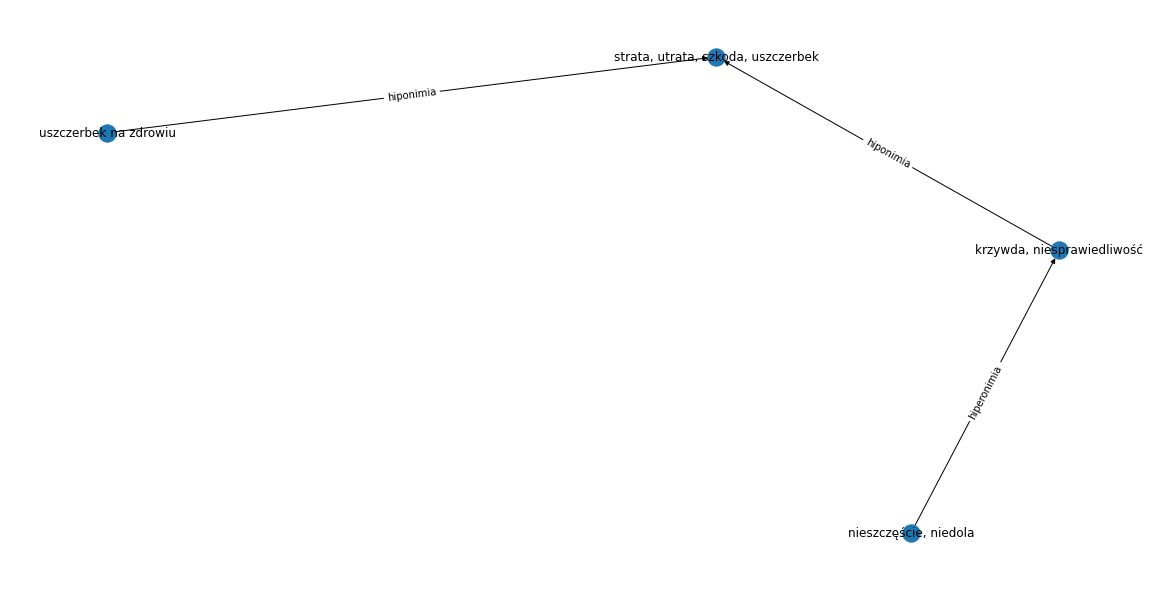

In [325]:
edges, labels = find_relations(synset_ids)
show_graph(edges, labels)

### wypadek$_{1}$, wypadek komunikacyjny$_{1}$, kolizja$_{2}$, zderzenie$_{2}$, kolizja drogowa$_{1}$, bezkolizyjny$_{2}$, katastrofa budowlana$_{1}$, wypadek drogowy$_{1}$.

Poniżej widoczny jest graf relacji dla zadanej grupy wyrażeń.

In [322]:
synset_ids = [
    get_synset_id('wypadek', meaning_no=1),
    get_synset_id('wypadek komunikacyjny', meaning_no=1),
    get_synset_id('kolizja', meaning_no=2),
    get_synset_id('zderzenie', meaning_no=2),
    get_synset_id('kolizja drogowa', meaning_no=1),
    get_synset_id('bezkolizyjny', meaning_no=2),
    get_synset_id('katastrofa budowlana', meaning_no=1),
    get_synset_id('wypadek drogowy', meaning_no=1),
]

wypadek komunikacyjny - hiponimia -> wypadek
katastrofa budowlana - hiponimia -> wypadek
wypadek - hiperonimia -> wypadek komunikacyjny
wypadek drogowy - hiponimia -> wypadek komunikacyjny
wypadek - hiperonimia -> katastrofa budowlana
wypadek komunikacyjny - hiperonimia -> wypadek drogowy


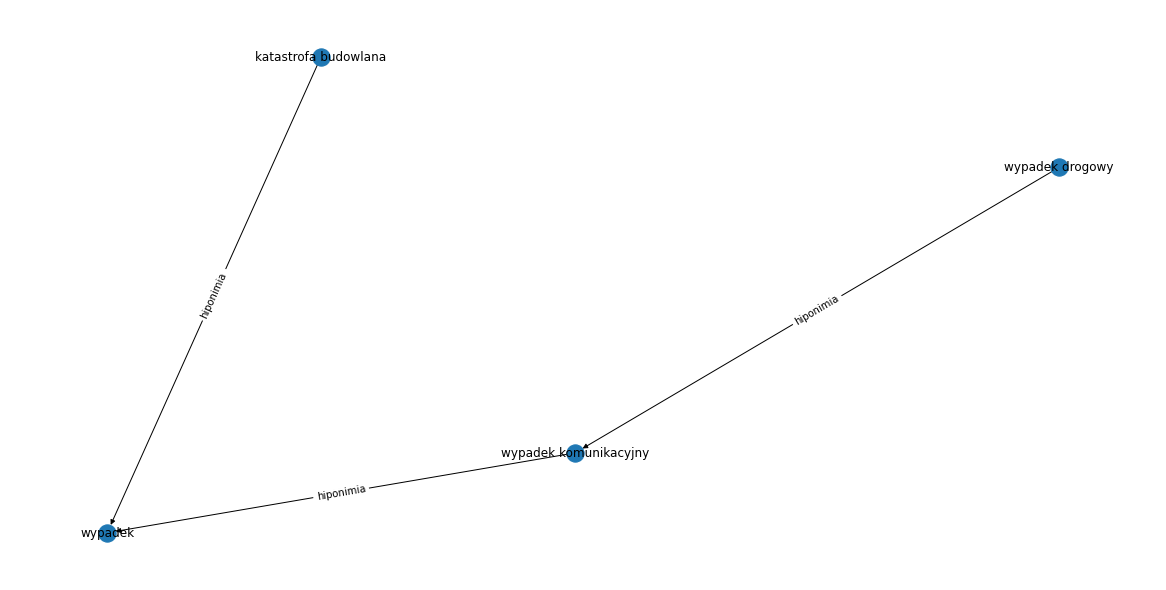

In [323]:
edges, labels = find_relations(synset_ids)
show_graph(edges, labels)

## Find the value of Leacock-Chodorow semantic similarity measure between following pairs of lexemes:

Do realizacji zadania wykorzystana została biblioteka `nltk` wraz z plikami Słowosieci pobranymi [ze strony PWR](http://www.nlp.pwr.wroc.pl/plwordnet/download/).

In [2]:
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### szkoda$_{2}$ - wypadek$_{1}$,

Dla pary _szkoda$_{2}$_ - _wypadek$_{1}$_ indeks podobieństwa Leacocka-Chodorowa wyniósł 2,74.

In [7]:
src = wn.synsets('szkoda')[1]
dest = wn.synsets('wypadek')[0]

wn.lch_similarity(src, dest)

2.740840023925201

### kolizja$_{2}$ - szkoda majątkowa$_{1}$,

Wyważenie _szkoda majątkowa$_1$_ nie zostało odnalezione w Słowosieci.

In [11]:
src = wn.synsets('kolizja')[1]
# dest = wn.synsets('szkoda majątkowa')[0]

# wn.lch_similarity(src, dest)

### nieszczęście$_{2}$ - katastrofa budowlana$_{1}$.

Wyważenie _katastrofa budowlana$_1$_ nie zostało odnalezione w Słowosieci.

In [15]:
src = wn.synsets('nieszczęście')[1]
# dest = wn.synsets('katastrofa budowlana')[0]

# wn.lch_similarity(src, dest)

## Questions/problems:

### What is the necessary step to use the knowlege from dictionaries such as WordNet?

Konieczne jest zapoznanie się z dokumentacją API oraz strukturą odpowiedzi. Ponadto należy mieć na uwadze, że Słowosieć zawiera słowa w formie podstawowej, zatem konieczny jest odpowieni preprocessing danych. Trzeba również uważać na niejednoznaczność słów. Poza tym wydaje mi się, że część definicji w polskiej Słowosieci nie jest nadmiernie wyczerpująca.

### Assess the value of WordNet as a resource for representing the sense of sentences (not words in isolation).
Słowosieć nie zawiera reprezentacji całych zdań, a jedynie konkretnych wyrażeń. Zdefiniowane relacje między słowami mogłyby być w pewnym stopniu pomocne przy analizie sensu zdania, chociażby poprzez wyszukiwanie synonimów, jednakże taka analiza relacji nie pomoże w ustaleniu istotności poszczególnych słów wpływających na sens wypowiedzi.

### Discuss the problems coming from using structured knowledge resources such as WordNet.
Słowosieć wymaga ręcznej aktualizacji, co jest problematyczne, biorąc pod uwagę dynamikę zmieniającego się języka. Przy realizacji zadania nie udało mi się znaleźć w niej części potrzebnych mi wyrażeń. Struktura Słowosieci wydaje się niewrażliwa na bardziej złożone wyrażenia. Podejrzewam, że problematyczne okazałyby się również wyrażenia metaforyczne. Przy bardziej skomplikowanej analizie należałoby również pamiętać o preprocessingu.